In [132]:
import ee
import numpy as np
import pandas as pd
import geopandas as gpd
from earthshot import mon_stats
from earthshot import water_viz as vis
from statistics import mean

In [133]:
ee.Initialize()
bbox_global = ee.Geometry.BBox(-180,-90,180,90)

In [134]:
def fc2df(fc):
    # Convert a FeatureCollection into a pandas DataFrame
    # Features is a list of dict with the output
    features = fc.getInfo()['features']

    dictarr = []

    for f in features:
        # Store all attributes in a dict
        attr = f['properties']
        # and treat geometry separately
        attr['geometry'] = f['geometry']  # GeoJSON Feature!
        # attr['geometrytype'] = f['geometry']['type']
        dictarr.append(attr)

    df = gpd.GeoDataFrame(dictarr)
    # Convert GeoJSON features to shape
    df['geometry'] = map(lambda s: np.shape(s), df.geometry)    
    return df

In [135]:
def extract_point_values(img_name, pts):
    image = img_name

    fc_image_red = image.reduceRegions(collection=pts,
                                  reducer=ee.Reducer.mean(),
                                  scale=30)

    # Convert to Pandas Dataframe
    df_image_red = fc2df(fc_image_red)


    return df_image_red

In [136]:
MAR_swales = ee.FeatureCollection('users/amgadellaboudy/Global_MAR_Inventory')

In [139]:
#Import variables in, clip to swale locations
slope_img = ee.Image('users/jamesmcc/merit_slope/merit_terrain_slope').clip(MAR_swales)

smap_usda_clim = ee.ImageCollection('users/jamesmcc/smap_usda_climatology')
avail_porosity = (smap_usda_clim
                  .filter(ee.Filter.eq('band', 'avail_porosity_mm')))
avail_porosity_img = avail_porosity.sum()
avail_porosity_img= avail_porosity_img.clip(MAR_swales)

runoff_clim = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY").select('surface_runoff')
runoff_clim_m = mon_stats.bands_avgs(['surface_runoff'], runoff_clim)
runoff_img = ee.ImageCollection(runoff_clim_m['avgs'].get('surface_runoff')).sum().multiply(720)
runoff_img = runoff_img.clip(MAR_swales)

soil_types = ee.Image("OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02")

top_soils = soil_types.expression('soil_0 + soil_10 + soil_30',
                             {'soil_0': soil_types.select('b0'),
                             'soil_10': soil_types.select('b10'),
                             'soil_30': soil_types.select('b30')})

bottom_soils = soil_types.expression('soil_60 + soil_100 + soil_200',
                                 {'soil_60': soil_types.select('b60'),
                                  'soil_100': soil_types.select('b100'),
                                  'soil_200': soil_types.select('b200')})

top_soil_img = top_soils.clip(MAR_swales)
bottom_soil_img = bottom_soils.clip(MAR_swales)

In [140]:
df_slope = extract_point_values(slope_img, MAR_swales)
df_slope.rename(columns = {'mean' : 'Slope'}, inplace = True)

porosity = extract_point_values(avail_porosity_img, MAR_swales)
porosity.rename(columns = {'mean' : 'Porosity'}, inplace = True)
porosity = porosity['Porosity']

runoff = extract_point_values(runoff_img, MAR_swales)
runoff.rename(columns = {'mean' : 'Runoff'}, inplace = True)
runoff = runoff['Runoff']

top_soil = extract_point_values(top_soil_img, MAR_swales)
top_soil.rename(columns = {'mean' : 'Top Soils'}, inplace = True)
top_soil = top_soil['Top Soils']

bottom_soil = extract_point_values(bottom_soil_img, MAR_swales)
bottom_soil.rename(columns = {'mean' : 'Bottom Soils'}, inplace = True)
bottom_soil = bottom_soil['Bottom Soils']

df_all = pd.concat([df_slope, porosity, runoff, top_soil, bottom_soil], axis = 1)

df_all.head()

/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


,continent,country,fid,final_use,id,influent_s,latitude,link_to_do,longitude,main_mar_t,...,reference_,site_name,specific_m,year_opera,year_shut_,geometry,Porosity,Runoff,Top Soils,Bottom Soils
0,Africa,Algeria,1125,Agricultural,1341,River water,36.538316,no data,3.061936,Spreading Methods,...,ANRH 2012,La Mitidja Big Bag,no data,2002,-9999,<map object at 0x7ff0dde2f5d0>,NaN,0.447128,21.0,15.0
1,North America,USA,1028,no data,1098,no data,35.372068,Reverse Drainage,-106.663641,Spreading Methods,...,"<a href=""http://www.nwri-usa.org/pdfs/MoorePre...",Mariposa Water Reclamation Facility Surface In...,Reverse Drainage,-9999,-9999,<map object at 0x7ff0dde2f5d0>,890.502527,0.045984,18.0,18.0
2,North America,USA,1064,Agricultural,1134,River water,45.945574,Reverse Drainage,-118.410467,Spreading Methods,...,"<a href=""http://wwbwc.org/aquifer-recharge-rep...",Anspach AR site,Reverse Drainage,2012,-9999,<map object at 0x7ff0dde2f5d0>,1184.378527,0.246399,21.0,18.0
3,Oceania,Australia,660,Domestic,718,Storm water,-33.918488,Reverse Drainage,151.227858,Spreading Methods,...,"<a href=""http://www.connectedwaters.unsw.edu.a...",Village Green/ Kensington University,Reverse Drainage,2006,-9999,<map object at 0x7ff0dde2f5d0>,1088.374790,0.135354,24.0,18.0
4,Oceania,Australia,654,Ecological,712,Reclaimed wastewater,-31.943780,Reverse Drainage,115.780462,Spreading Methods,...,"<a href=""http://www.clw.csiro.au/publications/...",Perry Lakes,Reverse Drainage,2008,-9999,<map object at 0x7ff0dde2f5d0>,NaN,0.143023,24.0,18.0


In [300]:
from sklearn.model_selection import train_test_split
df_new = df_all[['latitude','longitude','Slope','Porosity','Runoff','Top Soils','Bottom Soils','main_mar_t']].dropna()
X = df_new.drop('main_mar_t', axis =1)
y = df_new['main_mar_t']

In [319]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [326]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [327]:
rfc_pred = rfc.predict(X_test)

In [328]:
print(classification_report(y_test,rfc_pred))

                                   precision    recall  f1-score   support

          In-Channel Modification       0.81      0.79      0.80        33
          Induced Bank Filtration       0.70      0.79      0.75        24
 Rainwater and Run-off Harvesting       0.67      1.00      0.80         4
                Spreading Methods       0.57      0.58      0.58        48
Well, Shaft and Borehole Recharge       0.82      0.76      0.79        70

                         accuracy                           0.73       179
                        macro avg       0.71      0.78      0.74       179
                     weighted avg       0.73      0.73      0.73       179



In [284]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
scaled_features = scaler.transform(X)
df_feat = pd.DataFrame(scaled_features,columns = df_new.columns[:-1])
df_feat.head()

,latitude,longitude,Slope,Porosity,Runoff,Top Soils,Bottom Soils
0,0.342621,-1.230688,-0.090893,-0.411826,-0.611630,-0.455098,-0.176123
1,0.745353,-1.364727,-0.417088,0.090606,-0.486718,0.109198,-0.176123
2,-2.296572,1.712033,0.828246,-0.073529,-0.555929,0.673494,-0.176123
3,0.754549,0.056777,0.002358,-0.938539,0.577802,0.109198,0.298136
4,0.745434,-1.364858,-0.422180,0.090606,-0.486718,0.109198,-0.176123


In [310]:
X = df_feat
y= df_new['main_mar_t']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [316]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)

In [317]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,pred))

[[36  0  0  6  2]
 [ 0 19  0  5  2]
 [ 1  0  3  0  1]
 [ 4  8  1 22  9]
 [ 1  3  4 14 38]]


In [318]:
print(classification_report(y_test,pred))

                                   precision    recall  f1-score   support

          In-Channel Modification       0.86      0.82      0.84        44
          Induced Bank Filtration       0.63      0.73      0.68        26
 Rainwater and Run-off Harvesting       0.38      0.60      0.46         5
                Spreading Methods       0.47      0.50      0.48        44
Well, Shaft and Borehole Recharge       0.73      0.63      0.68        60

                         accuracy                           0.66       179
                        macro avg       0.61      0.66      0.63       179
                     weighted avg       0.67      0.66      0.66       179



In [314]:
error_rate=[]

for i in range(1,20):
    
    knn= KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

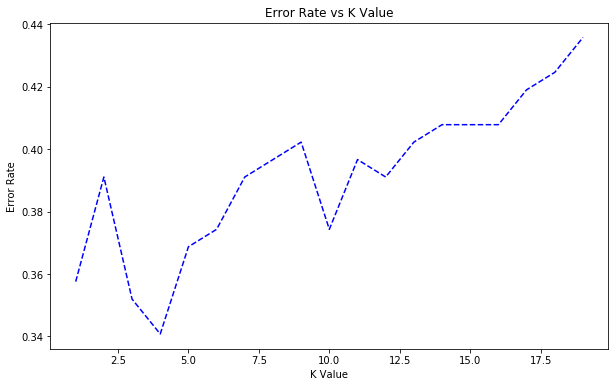

In [315]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color='blue',linestyle='dashed')
plt.title('Error Rate vs K Value')
plt.xlabel('K Value')
plt.ylabel('Error Rate')

In [289]:
dummies_mar = pd.get_dummies(df_new['main_mar_t'])
df_dummies = pd.concat([df_new,dummies_mar], axis = 1)
df_dummies = df_dummies.drop(['main_mar_t'], axis =1)
df_dummies.head()

,latitude,longitude,Slope,Porosity,Runoff,Top Soils,Bottom Soils,In-Channel Modification,Induced Bank Filtration,Rainwater and Run-off Harvesting,Spreading Methods,"Well, Shaft and Borehole Recharge"
1,35.372068,-106.663641,1.629380,890.502527,0.045984,18.0,18.0,0,0,0,1,0
2,45.945574,-118.410467,0.723436,1184.378527,0.246399,21.0,18.0,0,0,0,1,0
3,-33.918488,151.227858,4.182118,1088.374790,0.135354,24.0,18.0,0,0,0,1,0
5,46.187000,6.166000,1.888367,582.423523,1.954367,21.0,21.0,0,0,0,1,0
7,45.947697,-118.421937,0.709293,1184.378527,0.246399,21.0,18.0,0,0,0,1,0


In [290]:
X = df_dummies.drop(['In-Channel Modification', 'Spreading Methods', 'Induced Bank Filtration', 'Rainwater and Run-off Harvesting', 'Well, Shaft and Borehole Recharge'], axis = 1)
y = df_dummies['Induced Bank Filtration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [291]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [292]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

In [293]:
model = Sequential()

model.add(Dense(7, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = 'adam')

In [294]:
#setting up model for early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 250)

model.fit(x = X_train, y = y_train, validation_data = (X_test,y_test), batch_size = 256, epochs = 1000, callbacks = [early_stop])

Epoch 1/1000
3/3 [==============================] - 0s 53ms/step - loss: 1.2995 - val_loss: 1.0930
Epoch 2/1000
3/3 [==============================] - 0s 13ms/step - loss: 1.2765 - val_loss: 1.0670
Epoch 3/1000
3/3 [==============================] - 0s 17ms/step - loss: 1.2020 - val_loss: 1.0420
Epoch 4/1000
3/3 [==============================] - 0s 20ms/step - loss: 1.1915 - val_loss: 1.0179
Epoch 5/1000
3/3 [==============================] - 0s 30ms/step - loss: 1.1638 - val_loss: 0.9950
Epoch 6/1000
3/3 [==============================] - 0s 11ms/step - loss: 1.1214 - val_loss: 0.9732
Epoch 7/1000
3/3 [==============================] - 0s 28ms/step - loss: 1.0936 - val_loss: 0.9524
Epoch 8/1000
3/3 [==============================] - 0s 13ms/step - loss: 1.0615 - val_loss: 0.9326
Epoch 9/1000
3/3 [==============================] - 0s 17ms/step - loss: 1.0372 - val_loss: 0.9138
Epoch 10/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.9886 - val_loss: 0.8961
Epoch 11/

Epoch 83/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.6262 - val_loss: 0.6244
Epoch 84/1000
3/3 [==============================] - 0s 20ms/step - loss: 0.6256 - val_loss: 0.6236
Epoch 85/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.6262 - val_loss: 0.6229
Epoch 86/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.6267 - val_loss: 0.6221
Epoch 87/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.6234 - val_loss: 0.6213
Epoch 88/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.6240 - val_loss: 0.6206
Epoch 89/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.6215 - val_loss: 0.6198
Epoch 90/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.6204 - val_loss: 0.6190
Epoch 91/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.6205 - val_loss: 0.6183
Epoch 92/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.6207 - val_loss: 0.6175


3/3 [==============================] - 0s 10ms/step - loss: 0.5250 - val_loss: 0.5257
Epoch 246/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.5245 - val_loss: 0.5252
Epoch 247/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.5241 - val_loss: 0.5248
Epoch 248/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.5239 - val_loss: 0.5243
Epoch 249/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.5228 - val_loss: 0.5238
Epoch 250/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.5227 - val_loss: 0.5234
Epoch 251/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.5221 - val_loss: 0.5229
Epoch 252/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.5215 - val_loss: 0.5225
Epoch 253/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.5212 - val_loss: 0.5220
Epoch 254/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.5207 - val_loss: 0.5216
Epoch

3/3 [==============================] - 0s 14ms/step - loss: 0.4666 - val_loss: 0.4687
Epoch 408/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.4663 - val_loss: 0.4684
Epoch 409/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.4661 - val_loss: 0.4682
Epoch 410/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.4658 - val_loss: 0.4679
Epoch 411/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.4656 - val_loss: 0.4677
Epoch 412/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.4654 - val_loss: 0.4674
Epoch 413/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.4650 - val_loss: 0.4672
Epoch 414/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.4648 - val_loss: 0.4669
Epoch 415/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.4646 - val_loss: 0.4666
Epoch 416/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.4642 - val_loss: 0.4664
Epoch

3/3 [==============================] - 0s 15ms/step - loss: 0.4485 - val_loss: 0.4511
Epoch 489/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.4483 - val_loss: 0.4509
Epoch 490/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.4483 - val_loss: 0.4508
Epoch 491/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.4480 - val_loss: 0.4506
Epoch 492/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.4478 - val_loss: 0.4504
Epoch 493/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.4477 - val_loss: 0.4502
Epoch 494/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.4475 - val_loss: 0.4501
Epoch 495/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.4472 - val_loss: 0.4499
Epoch 496/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.4472 - val_loss: 0.4497
Epoch 497/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.4469 - val_loss: 0.4495
Epoch

3/3 [==============================] - 0s 14ms/step - loss: 0.4265 - val_loss: 0.4297
Epoch 651/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.4264 - val_loss: 0.4297
Epoch 652/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.4263 - val_loss: 0.4296
Epoch 653/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.4262 - val_loss: 0.4295
Epoch 654/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.4261 - val_loss: 0.4294
Epoch 655/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.4260 - val_loss: 0.4293
Epoch 656/1000
3/3 [==============================] - 0s 33ms/step - loss: 0.4259 - val_loss: 0.4292
Epoch 657/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.4258 - val_loss: 0.4291
Epoch 658/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.4257 - val_loss: 0.4290
Epoch 659/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.4257 - val_loss: 0.4289
Epoch

3/3 [==============================] - 0s 17ms/step - loss: 0.4160 - val_loss: 0.4198
Epoch 813/1000
3/3 [==============================] - 0s 20ms/step - loss: 0.4160 - val_loss: 0.4197
Epoch 814/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.4159 - val_loss: 0.4197
Epoch 815/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.4159 - val_loss: 0.4197
Epoch 816/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.4158 - val_loss: 0.4196
Epoch 817/1000
3/3 [==============================] - 0s 20ms/step - loss: 0.4158 - val_loss: 0.4196
Epoch 818/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.4157 - val_loss: 0.4195
Epoch 819/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.4157 - val_loss: 0.4195
Epoch 820/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.4156 - val_loss: 0.4194
Epoch 821/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.4156 - val_loss: 0.4194
Epoch

3/3 [==============================] - 0s 18ms/step - loss: 0.4114 - val_loss: 0.4156
Epoch 975/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.4114 - val_loss: 0.4155
Epoch 976/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.4114 - val_loss: 0.4155
Epoch 977/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.4113 - val_loss: 0.4155
Epoch 978/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.4113 - val_loss: 0.4155
Epoch 979/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.4113 - val_loss: 0.4155
Epoch 980/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.4113 - val_loss: 0.4155
Epoch 981/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.4113 - val_loss: 0.4154
Epoch 982/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.4113 - val_loss: 0.4154
Epoch 983/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.4112 - val_loss: 0.4154
Epoch 98

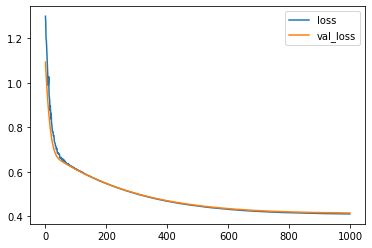

In [295]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()
#loss and validation loss vs. epochs

In [296]:
predictions = model.predict_classes(X_test)

In [250]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

In [251]:
from sklearn.metrics import classification_report, confusion_matrix

In [297]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       230
           1       0.00      0.00      0.00        39

    accuracy                           0.86       269
   macro avg       0.43      0.50      0.46       269
weighted avg       0.73      0.86      0.79       269



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [263]:
from sklearn.svm import SVC
model = SVC()
X = df_new.drop('main_mar_t', axis =1)
y = df_new['main_mar_t']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [264]:
predictions = model.predict(X_test)

In [265]:
print(confusion_matrix(y_test,predictions))

[[ 6  0  0  4 43]
 [ 0  0  0  0 38]
 [ 0  0  0  0 14]
 [ 0  0  0 15 52]
 [ 2  0  0  6 89]]


In [266]:
print(classification_report(y_test,predictions))

                                   precision    recall  f1-score   support

          In-Channel Modification       0.75      0.11      0.20        53
          Induced Bank Filtration       0.00      0.00      0.00        38
 Rainwater and Run-off Harvesting       0.00      0.00      0.00        14
                Spreading Methods       0.60      0.22      0.33        67
Well, Shaft and Borehole Recharge       0.38      0.92      0.53        97

                         accuracy                           0.41       269
                        macro avg       0.35      0.25      0.21       269
                     weighted avg       0.43      0.41      0.31       269



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
